### Import packages

In [2]:
# Package(s) related to time, space and id
import datetime, time
from datetime import timedelta
import platform
import random
import os

# You need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# Spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# Package(s) for data handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Tranport network analysis package
import transport_network_analysis.core as core
import transport_network_analysis.graph_module as graph_module
import transport_network_analysis.model as model

# Used for mathematical functions
import math             
from numpy.random import choice
from bisect import bisect

# Used for making the graph to visualize our problem
import networkx as nx  

### Import data for stations and transport lines

In [3]:
# Import stations and lines from csv 
df1 = pd.read_csv("Data/stations.csv", sep=";")
df2 = pd.read_csv("Data/lines.csv", sep=";")

# Convert columns to lst type\
from ast import literal_eval
df2.loc[:,'Route1'] = df2.loc[:,'Route1'].apply(lambda x: literal_eval(x))
df2.loc[:,'Route2'] = df2.loc[:,'Route2'].apply(lambda x: literal_eval(x))
df2.loc[:,'Duration'] = df2.loc[:,'Duration'].apply(lambda x: literal_eval(x)) 
df1.loc[:,'HalteLon'] = df1.loc[:,'HalteLon'].apply(lambda x: float(str(x).replace(',','.')))
df1.loc[:,'HalteLat'] = df1.loc[:,'HalteLat'].apply(lambda x: float(str(x).replace(',','.')))

In [4]:
# Create dictionary for all transport lines
lines = {}
durations = []

for index, row in df2.iterrows():
    lines[row["Line"] + "_0"] = (row["Route1"], row["Duration"], row["Start1"], row["Frequency"])
    lines[row["Line"] + "_1"] = (row["Route2"], row["Duration"], row["Start2"], row["Frequency"])
    
edges = []
for k, v in lines.items():
    for x in range(len(v[0])):
        try:
            edges.append((v[0][x], v[0][x + 1], k, v[1][x]))
        except:
            break

### Create graph

In [5]:
# Create graph
FG = nx.DiGraph()

# Create all stations and nodes
Node = type('Station', (core.Identifiable, core.Log, core.Locatable, core.HasResource, core.Station), {})
nodes = []
stations = []

for index, row in df1.iterrows():
    stations.append({"env": [],
                     "name": row["HalteNaam"],
                     "geometry": shapely.geometry.Point(row["HalteLat"], row["HalteLon"]),
                     "capacity": row["Capacity"]}) 

for station in stations:
    node = Node(**station)
    nodes.append(node)

# Create positions and add nodes to graph with right position
positions = {}

for node in nodes:
    positions[node.name] = (node.geometry.y, node.geometry.x)
    FG.add_node(node.name, geometry = node.geometry, object_type = node)

# Create all edges
for edge in edges:
    FG.add_edge(edge[0], edge[1], line = edge[2], duration = edge[3])

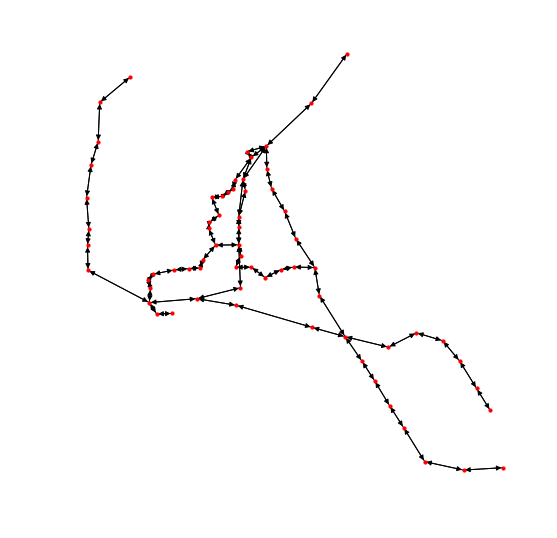

In [6]:
# Plot the network
plt.figure(figsize=(7,7)) 
# nx.draw(FG, positions, node_size=10, with_labels=True, font_size=10)
nx.draw(FG, positions, node_size=10)

### Route calculation and choice functions
#### Correctly calculate duration > including transfertime
#### Correctly calculate waiting time > time before start of the trip

In [7]:
def waitingtime(schedule, line, station, time):
    if time in schedule[line][station]:
        waiting = 0
    else:
        lineschedule = schedule[line][station]
        waiting = (lineschedule[bisect(lineschedule, time)] - time).seconds/60

    return waiting

In [8]:
def checkduplicates(route):
    if ('Roelof Hartplein', 'De Pijp') in zip(route, route[1:]):
        return True
    elif ('De Pijp', 'Roelof Hartplein') in zip(route, route[1:]):
        return True
    else:
        return False

def checkedge(station1, station2):
    if station1 == 'Roelof Hartplein' or station2 == 'Roelof Hartplein':
        if station1 == 'De Pijp' or station2 == 'De Pijp':
            return True
        else:
            return False
    else:
        return False

In [9]:
def route_calculation(env, route, graph, exception):
    schedule = env.timeschedule
    route_info = {"lines": [], "duration": 0, "transfers": 0, "waiting": 0, "transferstations": []}    

    for i in range(len(route) - 1):
        if route_info["lines"] != []:
            attr = FG.get_edge_data(route[i],route[i+1],default=0)
            newline = ''
            if checkedge(route[i], route[i+1]) == True:
                newline = exception + attr['line'][-2:]
            else:
                newline = attr['line']

                
            if line != newline:
                route_info["transfers"] += 1
                route_info["transferstations"].append(route[i])
                route_info["lines"].append(newline)
                line = newline
                
                duration = route_info["duration"] + route_info["waiting"]
                time = datetime.datetime.fromtimestamp(env.now) + timedelta(minutes = duration)
                
                route_info["duration"] += waitingtime(schedule, line, route[i], time)
            route_info["duration"] += attr['duration']
        
        else:
            attr = FG.get_edge_data(route[i],route[i+1],default=0)
            if checkedge(route[i], route[i+1]) == True:
                line = exception + attr['line'][-2:]
            else:
                line = attr['line']
               
            route_info["lines"].append(line)
            route_info["waiting"] = waitingtime(schedule, line, route[i], datetime.datetime.fromtimestamp(env.now))
            route_info["duration"] += attr['duration']

    return route_info

In [10]:
def calculate_schedule(lines, simhours, start):
    simulation_end = start + timedelta(hours = simhours)
    schedule = {}
    
    for line in lines:
        lineschedule = {}
        frequency = lines[line][3]
        now = start + timedelta(minutes = lines[line][2])
        timeschedule = [now]
        now = now + timedelta(minutes = frequency)
        
        while now < simulation_end:
            timeschedule.append(now)
            now = now + timedelta(minutes = frequency)
            
        lineschedule[lines[line][0][0]] = timeschedule

        for i in range(len(lines[line][0]) - 1):
            duration = lines[line][1][i]
            timeschedule = [x + timedelta(minutes = duration) for x in timeschedule]
            lineschedule[lines[line][0][i + 1]] = timeschedule
            
        schedule[line] = lineschedule
        
    return schedule

In [11]:
def route_choice(env, routes, classname):
    if classname == 0:
        minimum = routes[0][0]["duration"]
        index = 0
        for i in range(1, len(routes)):
            # Loop through all routes and save the route with the shortest trip duration
            if routes[i][0]["duration"] < minimum:
                minimum = routes[i][0]["duration"]
                index = i

            # If the duration is the same, save the route with the least waiting time
            elif routes[i][0]["duration"] == minimum:
                if routes[i][0]["waiting"] < routes[index][0]["waiting"]:
                    index = i

    elif classname == 1:
        minimum = routes[0][0]["waiting"]
        index = 0
        for i in range(1, len(routes)):
            # Loop through all routes and save the route with the least waiting time
            if routes[i][0]["waiting"] < minimum:
                minimum = routes[i][0]["waiting"]
                index = i

            # If waiting time is the same, save the route with the shortest duration
            elif routes[i][0]["waiting"] == minimum:
                if routes[i][0]["duration"] < routes[index][0]["duration"]:
                    index = i

    elif classname == 2:
        minimum = routes[0][0]["transfers"]
        index = 0
        for i in range(1, len(routes)):
            # Loop through all routes and save the route with the least transfers
            if routes[i][0]["transfers"] < minimum:
                minimum = routes[i][0]["transfers"]
                index = i

            # If the num of transfers is the same, save the route with the shortes duration
            elif routes[i][0]["transfers"] == minimum:
                if routes[i][0]["waiting"] < routes[index][0]["waiting"]:
                    index = i
                    
    return routes[index][0], routes[index][1]

### Create and spawn vehicles

In [12]:
def generate_vehicle(line, environment, linename):
    """ Generate a metro """
    Vehicle = type(linename, (core.Identifiable, core.Movable, core.HasContainer, core.HasResource, 
                           core.Routeable, core.Mover), {})
    # Name of the object
    name = linename

    # Travel direction
    route = line[0]  

    # Geometry of origin
    geometry = nx.get_node_attributes(environment.FG, "object_type")[route[0]].geometry
    
    # Maximum passengers
    capacity = 200
    
    return Vehicle(**{"env": environment, 
                    "name": name, 
                    "route": route, 
                    "capacity": capacity, 
                    "geometry": geometry
                   })

In [13]:
def vehicle(env, name):
    yield env.timeout(env.lines[name][2] * 60)
    while True:
        vehicle = generate_vehicle(env.lines[name], env, name)
        env.vehicles.append(vehicle)
        env.process(vehicle.move())
        
        # One vehicle every X minutes
        yield env.timeout(env.lines[name][3] * 60)

### Generate passengers based on data

In [14]:
origin = pd.read_csv("Data/origingrouped.csv")
destination = pd.read_csv("Data/destinationgrouped.csv")

gvborigin = {}
gvbdestination = {}

hours = list(set(origin['hour'].tolist()))

for hour in hours:
    df = origin[origin['hour'] == hour]
    stops = df['stop'].tolist()
    means = df['mean'].tolist()
    total = df['mean'].sum()
    
    percentages = []
    for i in range(len(stops)):
        percentages.append(means[i]/total)
        
    gvborigin[hour[:2]] = (total, stops, percentages)
    
for hour in hours:
    df = destination[destination['hour'] == hour]
    stops = df['stop'].tolist()
    means = df['mean'].tolist()
    total = df['mean'].sum()
    
    percentages = []
    for i in range(len(stops)):
        percentages.append(means[i]/total)
        
    gvbdestination[hour[:2]] = (total, stops, percentages)

In [15]:
def generate_passenger(origin, destination, classname, environment):
    """ Generate a passenger """
    Passenger = type('Passenger', (core.Identifiable, core.Routeable, core.Log), {})
    
    # Name of the object
    name = "Passenger"
    
    # Geometry of the origin
    geometry = nx.get_node_attributes(environment.FG, "object_type")[origin].geometry
 
    paths = nx.all_simple_paths(environment.FG, source = origin, target = destination)    
    
    routes = []
    for path in paths:
        if checkduplicates(path) == True:
            routes.append(((route_calculation(environment, path, environment.FG, 'tram12')), path))
            routes.append(((route_calculation(environment, path, environment.FG, 'tram24')), path))
        else:
            routes.append(((route_calculation(environment, path, environment.FG, '')), path))
     
    # Remove routes with more than 2 transfers to reduce computation
    routes = [route for route in routes if route[0]['transfers'] <= 2]

    # Travel direction and route information
    route_info, route = route_choice(environment, routes, classname)    
        
    return Passenger(**{"env": environment, 
                        "name": name, 
                        "route": route,
                        "route_info": route_info,
                        "transfers": route_info["transfers"],
                        "transferstations": route_info["transferstations"].copy(),
                        "duration": route_info["duration"],
                        "lines": route_info["lines"].copy(),
                        "class_id": classname
                        })

In [16]:
def passengers(env, origindata, destinationdata):
    # Store number of passengers, origin data and destination data
    # for the hour in a variable
    hour = datetime.datetime.fromtimestamp(env.now).strftime ('%H')
    classname = (choice([0, 1, 2], 1, p = env.probabilities))[0]
    numpassengers = origindata[hour][0]
    originstations = origindata[hour][1]
    originprobabilities = origindata[hour][2]
    
    destinationstations = destinationdata[hour][1]
    destinationprobabilities = destinationdata[hour][2]

    while True:
        newhour = datetime.datetime.fromtimestamp(env.now).strftime ('%H')
        if newhour == hour:
            origin = (choice(originstations, 1, p=originprobabilities))[0]
            destination = (choice(destinationstations, 1, p=destinationprobabilities))[0]
            
            # Run again if origin and destination are the same
            while origin == destination:
                origin = choice(originstations, 1, p=originprobabilities)[0]
                destination = choice(destinationstations, 1, p=destinationprobabilities)[0]

            # Create passenger and add to simulation
            passenger = generate_passenger(origin, destination, classname, env)
            FG.nodes[origin]["object_type"].units.append(passenger)
            passenger.log_entry("Waiting for {}".format(passenger.lines[0]), 
                                env.now, 0, nx.get_node_attributes(env.FG, "object_type")[origin].geometry)
            env.passengers.append(passenger)

            # Calculate timeout based on arrival rate
            timeout = (60*60) / numpassengers
            yield env.timeout(timeout)
            
        # If the hour is exceeded, update variables for the next hour
        else:
            hour = newhour
            numpassengers = origindata[hour][0]
            originstations = origindata[hour][1]
            originprobabilities = origindata[hour][2]

            destinationstations = destinationdata[hour][1]
            destinationprobabilities = destinationdata[hour][2]

### Run simulation

In [17]:
simulationhours = 20
simulation_start = datetime.datetime(2018, 1, 1, 6, 0)
schedule = calculate_schedule(lines, simulationhours, simulation_start)
schedule

{'metro52_0': {'Noord': [datetime.datetime(2018, 1, 1, 6, 0),
   datetime.datetime(2018, 1, 1, 6, 6),
   datetime.datetime(2018, 1, 1, 6, 12),
   datetime.datetime(2018, 1, 1, 6, 18),
   datetime.datetime(2018, 1, 1, 6, 24),
   datetime.datetime(2018, 1, 1, 6, 30),
   datetime.datetime(2018, 1, 1, 6, 36),
   datetime.datetime(2018, 1, 1, 6, 42),
   datetime.datetime(2018, 1, 1, 6, 48),
   datetime.datetime(2018, 1, 1, 6, 54),
   datetime.datetime(2018, 1, 1, 7, 0),
   datetime.datetime(2018, 1, 1, 7, 6),
   datetime.datetime(2018, 1, 1, 7, 12),
   datetime.datetime(2018, 1, 1, 7, 18),
   datetime.datetime(2018, 1, 1, 7, 24),
   datetime.datetime(2018, 1, 1, 7, 30),
   datetime.datetime(2018, 1, 1, 7, 36),
   datetime.datetime(2018, 1, 1, 7, 42),
   datetime.datetime(2018, 1, 1, 7, 48),
   datetime.datetime(2018, 1, 1, 7, 54),
   datetime.datetime(2018, 1, 1, 8, 0),
   datetime.datetime(2018, 1, 1, 8, 6),
   datetime.datetime(2018, 1, 1, 8, 12),
   datetime.datetime(2018, 1, 1, 8, 18),


In [97]:
%%time
# Simulation start time
simulationhours = 1

# Simulation starts = 8, 11, 14, 17, 20
simulation_start = datetime.datetime(2018, 1, 1, 6, 0)

# Make simulation environment
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
env.FG = FG

# For loggin
env.vehicles = []
env.passengers = []
env.lines = lines
env.timeschedule = schedule
env.probabilities = [1, 0, 0]

# Start the simulation
for line in env.lines.keys():
    env.process(vehicle(env, line))

env.process(passengers(env, gvborigin, gvbdestination))
env.run(until = env.now + simulationhours * 60 * 60)

CPU times: user 34 s, sys: 54.2 ms, total: 34.1 s
Wall time: 34.1 s


### Check results

### Store passenger and vehicle data

In [117]:
passengerdict = {}

for i in range(len(env.passengers)):
    try:
            passengerdict[env.passengers[i].id] = {"route": env.passengers[i].route,
                                        "origin": env.passengers[i].route[0],
                                        "destination": env.passengers[i].route[-1], 
                                        "transfers": env.passengers[i].route_info['transfers'], 
                                        "lines": env.passengers[i].route_info['lines'], 
                                        "duration": env.passengers[i].route_info['duration'], 
                                        "transferstations": env.passengers[i].route_info['transferstations'],
                                        "creation": env.passengers[i].log["Timestamp"][0].strftime ('%H:%M:%S'),
                                        "departure": env.passengers[i].log["Timestamp"][2].strftime ('%H:%M:%S'),
                                        "arrival": env.passengers[i].log["Timestamp"][3].strftime ('%H:%M:%S'), 
                                        "date": env.passengers[i].log["Timestamp"][0].date(),
                                        "class_id": env.passengers[i].class_id,
                                        "waiting_time": env.passengers[i].route_info['waiting']}
    except:
        pass
    
passengerdf = pd.DataFrame(passengerdict).T
passengerdf.to_csv("../../Results/passengers_round_1.csv", index=True)

,arrival,class_id,creation,date,departure,destination,duration,lines,origin,route,transfers,transferstations,waiting_time
8a0c76ac-82bf-11e9-b98a-7831c1d08f6a,06:24:00,0,06:01:08,2018-01-01,06:03:00,Koningsplein,33,"[metro53_0, tram24_0, tram12_0]",Gaasperplas,"[Gaasperplas, Kraaienneststation, Station Ganz...",2,"[Centraal Station, Dam]",1.85
8aa08f06-82bf-11e9-9947-7831c1d08f6a,06:17:00,0,06:03:02,2018-01-01,06:04:00,Amstelstation,29,"[metro50_0, metro52_1, tram12_0]",Station Sloterdijk,"[Station Sloterdijk, Burg.de Vlugtlaan, Jan v....",2,"[Station Zuid, De Pijp]",0.95
8b09381a-82bf-11e9-847b-7831c1d08f6a,06:17:00,0,06:04:03,2018-01-01,06:05:00,Amstelstation,28,"[metro50_0, metro52_1, tram12_0]",Burg.de Vlugtlaan,"[Burg.de Vlugtlaan, Jan v.Galenstraat, Postjes...",2,"[Station Zuid, De Pijp]",0.933333
8b3318e2-82bf-11e9-8cf9-7831c1d08f6a,06:34:00,0,06:04:33,2018-01-01,06:13:00,Nieuwezijds Kolk,24,"[metro53_0, tram12_0]",Gaasperplas,"[Gaasperplas, Kraaienneststation, Station Ganz...",1,[Centraal Station],8.43333
8b575586-82bf-11e9-8f85-7831c1d08f6a,06:10:00,0,06:04:53,2018-01-01,06:06:00,Leidseplein,16,"[metro52_0, tram12_0]",Noord,"[Noord, Noorderpark, Centraal Station, Nieuwez...",1,[Centraal Station],1.1
8b73e836-82bf-11e9-81b1-7831c1d08f6a,06:21:00,0,06:05:05,2018-01-01,06:14:00,Koningsplein,28,"[metro50_1, metro53_0, tram12_0]",Station Holendrecht,"[Station Holendrecht, Bullewijk, Station Bijlm...",2,"[Van der Madeweg, Centraal Station]",8.9
8baa5542-82bf-11e9-aa69-7831c1d08f6a,06:10:00,0,06:05:42,2018-01-01,06:06:00,Koningsplein,12,"[metro52_0, tram12_0]",Noord,"[Noord, Noorderpark, Centraal Station, Nieuwez...",1,[Centraal Station],0.283333
8bd5698a-82bf-11e9-8936-7831c1d08f6a,06:27:00,0,06:06:13,2018-01-01,06:15:00,Amstelstation,30,"[metro50_0, metro52_1, tram12_0]",Burg.de Vlugtlaan,"[Burg.de Vlugtlaan, Jan v.Galenstraat, Postjes...",2,"[Station Zuid, De Pijp]",8.76667
8c74c32c-82bf-11e9-b080-7831c1d08f6a,06:33:00,0,06:08:02,2018-01-01,06:24:00,Amstelstation,9,[tram12_0],De Pijp,"[De Pijp, Cornelis Troostplein, Scheldestraat,...",0,[],15.95
8c8d9bc2-82bf-11e9-b92e-7831c1d08f6a,06:27:00,0,06:08:20,2018-01-01,06:14:00,Amstelstation,31,"[metro50_0, metro52_1, tram12_0]",Station Sloterdijk,"[Station Sloterdijk, Burg.de Vlugtlaan, Jan v....",2,"[Station Zuid, De Pijp]",5.65


In [118]:
vehicledict = {}

for i in range(len(env.vehicles)):
    try:
        vehicledict[env.vehicles[i].id] = {"route": env.vehicles[i].route, 
                                        "occupancy": list(zip(env.vehicles[i].log['Message'], 
                                                              env.vehicles[i].log['Value'])),
                                        "line": env.vehicles[i].name, 
                                        "departure": env.vehicles[i].log["Timestamp"][0].strftime ('%H:%M:%S'),
                                        "arrival": env.vehicles[i].log["Timestamp"][-1].strftime ('%H:%M:%S'), 
                                        "date": env.vehicles[i].log["Timestamp"][0].date()}
    except:
        pass
    
vehicledf = pd.DataFrame(vehicledict).T
vehicledf.to_csv("../../Results/vehicles_round_1.csv", index=True)